In [214]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

import torchinfo
from torchinfo import summary

import matplotlib
import matplotlib.pyplot as plt

import tqdm as tqdm_version_check
from tqdm import tqdm

import pandas as pd
import numpy as np
from pathlib import Path
import zipfile
import re
from PIL import Image

import itertools
import zipfile
import re

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from PIL import Image, ImageFile

from sklearn import preprocessing
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler, DataLoader
from torchvision import transforms, models

CSV_PATH = Path("data/train_info.csv")
IMAGE_DIR = Path("data/train")

print(f"Torch version : {torch.__version__}")
print(f"Torchvision version : {torchvision.__version__}")
print(f"Torchinfo version : {torchinfo.__version__}")
print(f"Matplotlib version : {matplotlib.__version__}")
print(f"TQDM version : {tqdm_version_check.__version__}")

Torch version : 2.5.1
Torchvision version : 0.20.1
Torchinfo version : 1.8.0
Matplotlib version : 3.10.8
TQDM version : 4.67.1


In [159]:
def plot_cm(cfmatrix,title,classes):
    fig, ax1 = plt.subplots(1,1) #, figsize=(5,5)

    for ax,cm in zip([ax1],[cfmatrix]):
        im = ax.imshow(cm, interpolation='nearest', cmap=mycmap)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=.2)
        plt.colorbar(im, cax=cax) #, ticks=[-1,-0.5,0,0.5,1]
        ax.set_title(title,fontsize=14)
        tick_marks = np.arange(len(classes))
        ax.set_xticks(tick_marks)
        ax.set_xticklabels(classes, rotation=90)
        ax.set_yticks(tick_marks)
        ax.set_yticklabels(classes)

        fmt = 'd'
        thresh = cm.max() / 2.

        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            ax.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

        ax.set_ylabel('True label',fontsize=14)
        ax.set_xlabel('Predicted label',fontsize=14)

    plt.savefig(title+'.pdf', bbox_inches='tight')
    plt.show()


In [160]:
Image.MAX_IMAGE_PIXELS = None
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [179]:
import os
from PIL import Image


transform = transforms.Compose([
    transforms.Resize(255), 
    transforms.CenterCrop(224),  
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()]
)

def filter_large_images(root, max_pixels=2_000_000):
    valid_paths = []
    for subdir, _, files in os.walk(root):
        for f in files:
            path = os.path.join(subdir, f)
            try:
                with Image.open(path) as im:
                    if im.width * im.height <= max_pixels:
                        valid_paths.append(path)
            except:
                pass
    return valid_paths

# Use the valid paths to build a custom dataset
from torchvision.datasets import DatasetFolder
import torch
from torch.utils.data import Dataset
from PIL import Image

class SafeImageDataset(Dataset):
    def __init__(self, paths, labels=None, transform=None):
        self.paths = paths
        self.transform = transform
        # If you have class labels per image, supply them, otherwise 0
        if labels is None:
            self.labels = [0] * len(paths)
        else:
            self.labels = labels

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        label = self.labels[idx]
        with Image.open(img_path) as im:
            im = im.convert("RGB")
            if self.transform:
                im = self.transform(im)
        return im, label

# Run it
valid_paths = filter_large_images("data/dataset", max_pixels=2_000_000)
train_data = SafeImageDataset(valid_paths, transform=transform)

In [182]:
data_root = "data/dataset"
class_names = sorted(entry.name for entry in os.scandir(data_root) if entry.is_dir())
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}
idx_to_class = {idx: class_name for class_name, idx in class_to_idx.items()}

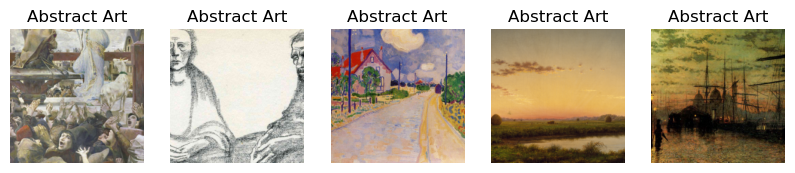

In [183]:
fig = plt.figure(figsize=(10,10))
row , col = 1,5
for i in range (1,(row * col) + 1):
    id = torch.randint(size=[1],low = 0 , high=len(train_data)).item()
    img , label = train_data[id]
    fig.add_subplot(row , col , i)
    plt.imshow(img.permute(1,2,0))
    plt.title(class_names[label])
    plt.axis(False)

In [184]:
COLOUR_CHANNELS,HEIGHT,WIDTH = train_data[0][0].shape[0],train_data[0][0].shape[1],train_data[0][0].shape[2]
COLOUR_CHANNELS,HEIGHT,WIDTH

(3, 224, 224)

In [185]:
import torch
from torch.utils.data import DataLoader, random_split

# 1. Define your split sizes (e.g., 70% Train, 15% Val, 15% Test)
train_size = int(0.7 * len(train_data))
val_size = int(0.15 * len(train_data))
test_size = len(train_data) - train_size - val_size

# 2. Use random_split to get the Subset objects
train_ds, val_ds, test_ds = random_split(
    train_data, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

# 3. Use them directly in your DataLoaders


In [202]:
import os
BATCH_SIZE = 32
num_workers = 0

In [203]:
train_dataloader = DataLoader(
  train_ds,
  batch_size=BATCH_SIZE,
  shuffle=True,
  num_workers=num_workers
  )

validation_dataloader = DataLoader(
  val_ds,
  batch_size=BATCH_SIZE,
  shuffle=True,
  num_workers=num_workers
  )


test_dataloader = DataLoader(
  test_ds,
  batch_size=BATCH_SIZE,
  shuffle=False,
  num_workers=num_workers,
  pin_memory=True,
)

In [188]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [194]:
model_conv = models.resnet18(pretrained=True)

In [190]:
summary(model_conv, input_size=(BATCH_SIZE, COLOUR_CHANNELS, HEIGHT, WIDTH))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1000]                --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│

In [195]:
output_shape = len(class_names)

model_conv.fc = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(
        in_features=model_conv.fc.in_features,
        out_features=output_shape,
        bias=True
    )
)

model_conv = model_conv.to(device)


In [196]:
print(model_conv.fc)


Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=512, out_features=135, bias=True)
)


In [197]:
optimizer = torch.optim.Adam(model_conv.parameters(), lr=0.00005, weight_decay=1e-6)
criterion = nn.CrossEntropyLoss()

In [209]:
for param in model_conv.parameters():
    param.requires_grad = False

for param in model_conv.fc.parameters():
    param.requires_grad = True



In [210]:
for name, p in model_conv.named_parameters():
    if p.requires_grad:
        print(name)

fc.1.weight
fc.1.bias


In [211]:
summary(model_conv, input_size=(BATCH_SIZE, COLOUR_CHANNELS, HEIGHT, WIDTH))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 135]                 --
├─Conv2d: 1-1                            [32, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]  

In [212]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [ ]:
learning_rate = 1e-5
weight_decay = 1e-6
patience = 10
verbose_ct = 1
num_epochs = 20  

criterion = nn.CrossEntropyLoss()  # change if needed

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model_conv.parameters()),
    lr=learning_rate,
    weight_decay=weight_decay
)

model_conv.to(device)

# =====================
# Early Stopping State
# =====================
best_val_loss = float("inf")
epochs_no_improve = 0
best_state_dict = None

# =====================
# Training Loop
# =====================
for epoch in tqdm(range(1, num_epochs + 1)):

    # ---- Train ----
    model_conv.train()
    train_loss = 0.0

    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        preds = model_conv(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)

    train_loss /= len(train_dataloader.dataset)

    # ---- Validation ----
    model_conv.eval()
    val_loss = 0.0

    with torch.no_grad():
        for x, y in validation_dataloader:
            x, y = x.to(device), y.to(device)
            preds = model_conv(x)
            loss = criterion(preds, y)
            val_loss += loss.item() * x.size(0)

    val_loss /= len(validation_dataloader.dataset)

    # ---- Logging ----
    if verbose_ct and epoch % verbose_ct == 0:
        print(
            f"Epoch {epoch:4d} | "
            f"train_loss={train_loss:.6f} | "
            f"val_loss={val_loss:.6f}"
        )

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_state_dict = {k: v.clone() for k, v in model_conv.state_dict().items()}
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        if verbose_ct:
            print(f"Early stopping triggered at epoch {epoch}")
        break


if best_state_dict is not None:
    model_conv.load_state_dict(best_state_dict)

  5%|▌         | 1/20 [07:05<2:14:35, 425.05s/it]

Epoch    1 | train_loss=0.000347 | val_loss=0.000045


 10%|█         | 2/20 [14:13<2:08:07, 427.06s/it]

Epoch    2 | train_loss=0.000029 | val_loss=0.000013
